# 1. Libraries & Sample Data
The first step is to load our Python Libraries and download the sample data. The dataset represents Apple stock price (1d bars) for the year 2010

In [1]:
# Load Python Libraries
import math
import keras
import random
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tqdm.notebook import tqdm
from collections import deque
from IPython.display import display, HTML
from sklearn.preprocessing import StandardScaler

# for dataframe display
pd.set_option('display.max_rows', None)
def display_df(df):
    # Puts the scrollbar next to the DataFrame
    display(HTML("<div style='height: 200px; overflow: auto; width: fit-content'>" + df.to_html() + "</div>"))

# for reproducability of training rounds
keras.utils.set_random_seed(42)

2024-12-17 17:28:34.921517: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Download Sample Data
data = pd.read_csv('GOOG_2009-2010_6m_RAW_1d.csv')

# 2. Exploratory Data Analysis
Next, we want to analyze our data. Display the data as a dataframe, and plot some relevant data so you can get an idea of what our dataset looks like.

In [3]:
# Display as Dataframe
display_df(data)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-04-01,8.562406,8.847836,8.483452,8.819193,8.819193,132542948.0
1,2009-04-02,9.048833,9.209481,8.974362,9.028658,9.028658,180192885.0
2,2009-04-03,9.078472,9.258298,8.916578,9.209979,9.209979,152160204.0
3,2009-04-06,9.140738,9.210975,9.001261,9.171623,9.171623,131703815.0
4,2009-04-07,NaN,NaN,NaN,NaN,NaN,NaN
5,2009-04-08,9.053565,9.090925,8.871996,9.016205,9.016205,111022586.0
6,2009-04-09,9.203005,9.323802,9.122058,9.277725,9.277725,135811153.0
7,2009-04-13,9.248584,9.442109,9.222930,9.417451,9.417451,122461301.0
8,2009-04-14,9.388310,9.389556,9.105869,9.188310,9.188310,137658049.0
9,2009-04-15,9.143229,9.490926,9.070003,9.452071,9.452071,197967259.0


In [4]:
# Index data by Date
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

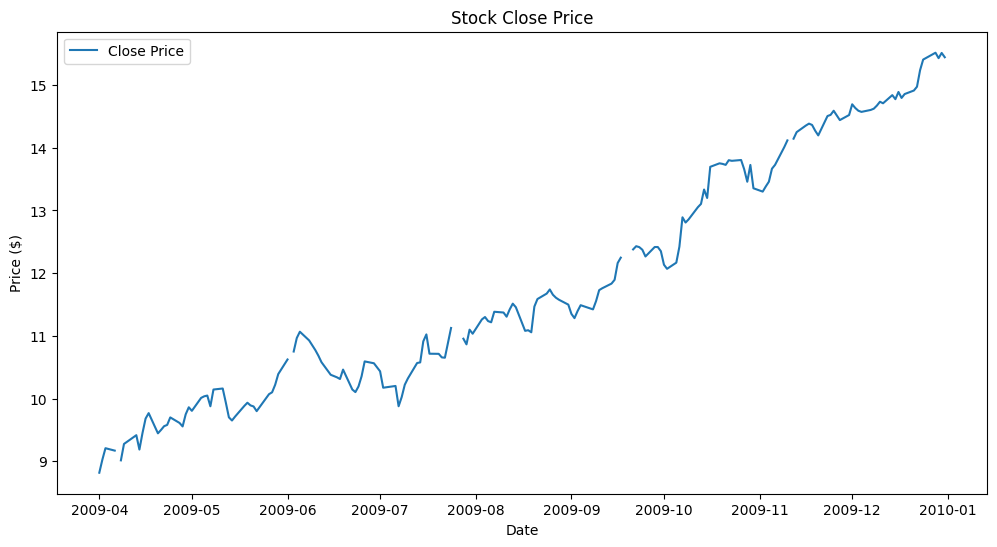

In [5]:
# Plot the Close Data
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 3. Data Cleaning
Next, we need to clean our data for training our model. This requires removal of NaN values.

In [6]:
# Check for null values
null_values = data.isnull().sum().to_frame(name='Null Values')
display_df(null_values)

,Null Values
Open,5
High,5
Low,5
Close,5
Adj Close,5
Volume,5


In [7]:
# forward fill missing values
data = data.fillna(method='ffill')

/tmp/ipykernel_2233347/2143843241.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


In [8]:
# Check for null values
null_values = data.isnull().sum().to_frame(name='Null Values')
display_df(null_values)

,Null Values
Open,0
High,0
Low,0
Close,0
Adj Close,0
Volume,0


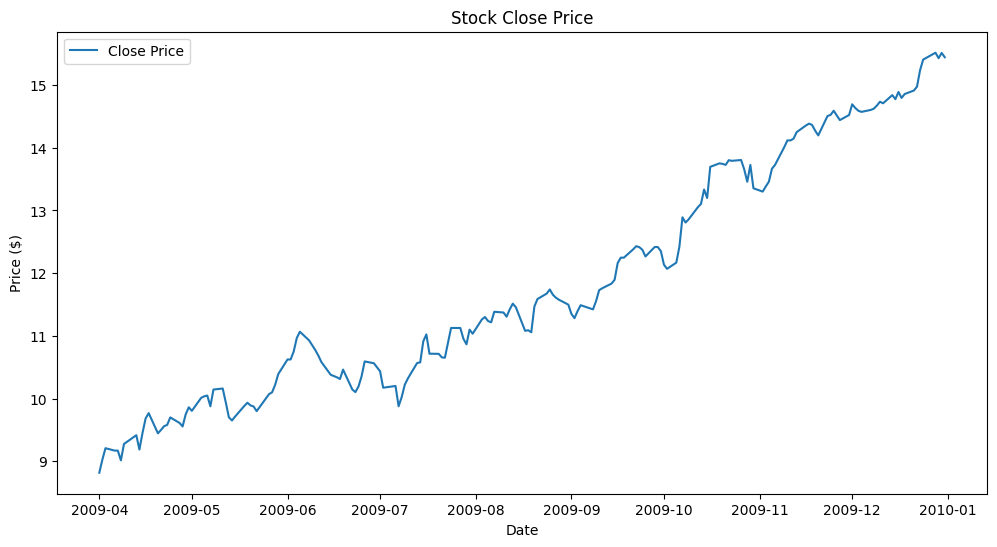

In [9]:
# Plot the cleaned Close Data
# Plot the Close Data
plt.figure(figsize=(12,6))
plt.plot(data['Close'], label='Close Price')
plt.title('Stock Close Price')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

# 4. Feature Selection
Now that we have cleaned our stock data, we need to select which features to train our model on. For this project, we will be training with Close data and 20-day Bollinger Bands of Close.

In [10]:
# Calculate 20-day bollinger bands
# Calculate 20-day bollinger bands
data['MA20'] = data['Close'].rolling(window=20).mean()
data['STD20'] = data['Close'].rolling(window=20).std()
data['UpperBB'] = data['MA20'] + (2 * data['STD20'])
data['LowerBB'] = data['MA20'] - (2 * data['STD20'])


In [11]:
# Remove rows with NaN bollinger bands
data = data.dropna(subset=['UpperBB', 'LowerBB'])

In [12]:
# Define new dataframe with only the training features (Close, Upper BB, Lower BB)
dataset = data[['Close', 'UpperBB', 'LowerBB']]

# 5. Normalization
Now that we have cleaned our data, created our indicators of interest, and selected our features, we must normalize our data. For this project, we use the sklearn StandardScaler, which centers the data and normalizes to unit variance. We will not be using a rolling scaler for this project, due to the complexity of back-translating to true proce and indicator values - you can try this yourself once you have completed the project. 

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,9.750204,9.937823,8.853717
2009-04-30,9.862284,9.956057,8.939792
2009-05-01,9.805497,9.978454,8.995079
2009-05-04,10.011973,10.053107,9.000625
2009-05-05,10.037128,10.115385,9.024898
2009-05-06,10.049084,10.165415,9.062614
2009-05-07,9.878224,10.142584,9.171646
2009-05-08,10.145223,10.198098,9.202882
2009-05-11,10.161413,10.256965,9.218412


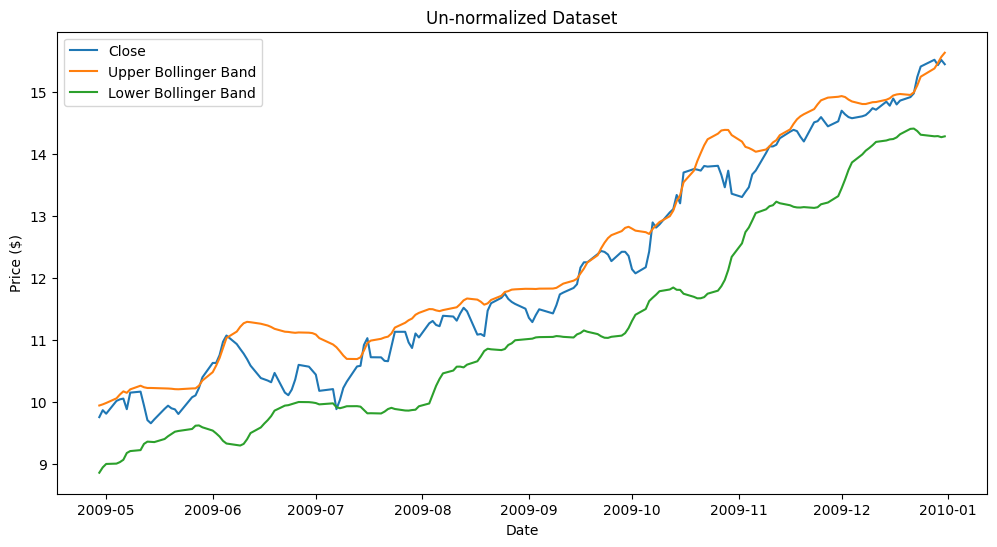

In [13]:
# Display & Plot Un-normalized Dataset
display_df(dataset)

# Plot the features
plt.figure(figsize=(12,6))
plt.plot(dataset['Close'], label='Close')
plt.plot(dataset['UpperBB'], label='Upper Bollinger Band')
plt.plot(dataset['LowerBB'], label='Lower Bollinger Band')
plt.title('Un-normalized Dataset')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [14]:
# Normalize Dataset with StandardScaler
normlist = []
normed_dataset = pd.DataFrame(index=dataset.index)
for col in dataset.columns:
    normalizer = StandardScaler()
    column_data = dataset[[col]].values
    normalizer.fit(column_data)
    transformed_data = normalizer.transform(column_data)
    normed_dataset[col] = transformed_data.flatten()
    normlist.append(normalizer)


,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


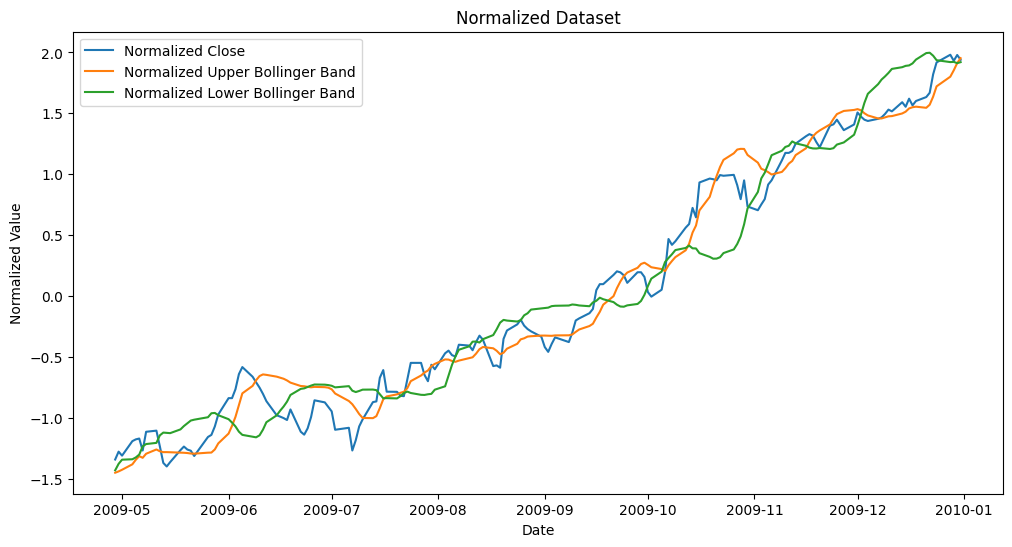

In [15]:
# Display & Plot Normalized Dataset
display_df(normed_dataset)

# Plot the normalized features
plt.figure(figsize=(12,6))
plt.plot(normed_dataset['Close'], label='Normalized Close')
plt.plot(normed_dataset['UpperBB'], label='Normalized Upper Bollinger Band')
plt.plot(normed_dataset['LowerBB'], label='Normalized Lower Bollinger Band')
plt.title('Normalized Dataset')
plt.xlabel('Date')
plt.ylabel('Normalized Value')
plt.legend()
plt.show()

# 6. Train / Test Split
Now that our data cleaned, features are selected, and the dataset is normalized, we are ready to feed the data into our model. With this in mind, we split the data ito train and test data (50/50 split)

In [16]:
# split dataset df into train (50%) and test (50%) datasets

split_index = int(len(normed_dataset) * 0.5)
train_df = normed_dataset.iloc[:split_index]
test_df = normed_dataset.iloc[split_index:]

In [17]:
# display train and test dfs (ensure no overlap)
display_df(train_df)
display_df(test_df)

# Ensure no overlap
assert train_df.index.intersection(test_df.index).empty, "Train and Test sets overlap!"

,Close,UpperBB,LowerBB
Date,,,
2009-04-29,-1.341805,-1.450150,-1.430416
2009-04-30,-1.277192,-1.439244,-1.377255
2009-05-01,-1.309929,-1.425848,-1.343109
2009-05-04,-1.190897,-1.381197,-1.339683
2009-05-05,-1.176395,-1.343949,-1.324692
2009-05-06,-1.169503,-1.314025,-1.301398
2009-05-07,-1.268002,-1.327681,-1.234058
2009-05-08,-1.114080,-1.294477,-1.214766
2009-05-11,-1.104746,-1.259269,-1.205175


,Close,UpperBB,LowerBB
Date,,,
2009-08-31,-0.333839,-0.324508,-0.101821
2009-09-01,-0.418697,-0.324366,-0.098844
2009-09-02,-0.458183,-0.325247,-0.095058
2009-09-03,-0.393426,-0.326468,-0.082783
2009-09-04,-0.339151,-0.323058,-0.079844
2009-09-08,-0.377632,-0.322125,-0.077715
2009-09-09,-0.300814,-0.315388,-0.069243
2009-09-10,-0.200735,-0.294361,-0.071943
2009-09-11,-0.183505,-0.274560,-0.077222


In [18]:
# convert train and test dfs to np arrays with dtype=float
X_train = train_df.to_numpy(dtype=float)
X_test = test_df.to_numpy(dtype=float)
# print the shape of X_train to remind yourself how many examples and features are in the dataset
print(X_train.shape)
# track index to remember which feature is which
idx_close = 0
idx_bb_upper = 1
idx_bb_lower = 2

(86, 3)


# 7. Define the Agent
Now that our data is ready to use, we can define the Reinforcement Learning Agent.

### Define the DQN Model
The first step in defining our agent is the Deep Q-Network model definition. For this project, we are creating a model sequential model with four layers. The first three layers have output shape of 64, 32, and 8, respectively, and a RELU activation. The output layer has an output shape of the size of our action space (buy, sell, hold), and a linear activation. Our Loss finction is Mean Squared Error, and our optimizer is Adam with a learning rate of 0.001. Use Keras to build this model.

In [19]:
@keras.saving.register_keras_serializable()
# Define DQN Model Architecture
class DQN(keras.Model):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        model = keras.Sequential([
            keras.layers.Dense(64, activation='relu', input_shape=(state_size,)),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(8, activation='relu'),
            keras.layers.Dense(action_size, activation='linear')
        ])
        
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
        
        # save model to DQN instance
        self.model = model


### Define Agent Class
Now that we have defined our underlying DQN Model, we must define out Reinforcement Learning Agent. The agent initialization is provided for you, you must define an act function, and an expereince replay function. As a reminder, the act function defines how our model will act (buy, hold, or sell) given a certain state. The Experience Replay function tackles catastrophic forgetting in our training process, by maintaining a memory buffer to allow training on independent / randomized minibatches of previous states. 

In [20]:
class Agent:
    def __init__(self, window_size, num_features, test_mode=False, model_name=''):
        self.window_size = window_size
        self.num_features = num_features
        self.state_size = window_size * num_features
        self.action_size = 3  # 0=hold, 1=buy, 2=sell
        self.memory = deque(maxlen=1000)
        self.inventory = []
        self.model_name = model_name
        self.test_mode = test_mode

        self.gamma = 0.95
        self.epsilon = 1.0  # = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.90

        self.model = keras.models.load_model(model_name) if test_mode else self._model()

    # Deep Q Learning (DQL) model
    def _model(self):
        model = DQN(self.state_size, self.action_size).model
        return model

    # DQL Predict (with input reshaping)
    def get_q_values_for_state(self, state):
        return self.model.predict(state.flatten().reshape(1, self.state_size))

    # DQL Fit (with input reshaping)
    def fit_model(self, input_state, target_output):
        return self.model.fit(input_state.flatten().reshape(1, self.state_size), target_output, epochs=1, verbose=0)

    # Agent Action Selector
    def act(self, state):
        # Random action based on epsilon
        if not self.test_mode and random.random() <= self.epsilon:
            return random.randrange(self.action_size)
        # Predict the best action using the model
        q_values = self.get_q_values_for_state(state)
        noise = np.random.randn(*q_values.shape) * 0.01  # Add small noise
        return np.argmax(q_values[0] + noise)

    # Experience Replay (Learning Function)
    def exp_replay(self, batch_size, losses):
        losses = []
        mini_batch = random.sample(self.memory, min(len(self.memory), batch_size))
        for state, action, reward, next_state, done in mini_batch:
            if done:
                optimal_q_for_action = reward
            else:
                optimal_q_for_action = reward + self.gamma * np.max(self.get_q_values_for_state(next_state)[0])

            target_q_table = self.get_q_values_for_state(state)
            target_q_table[0][action] = optimal_q_for_action

            history = self.fit_model(state, target_q_table)
            losses += history.history['loss']

        # Epsilon decay
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return losses


# 8. Train the Agent
Now that our data is ready and our agent is defined, we are ready to train the agent. 

### Helper Functions
Before we define the training loop, we will write some helper functions: one for printing price data, one to define the sigmoid funtion, one to grab the state representation,  one to plot the trading output of our trained model, and one to plot the training loss. The printing, sigmoid, and plotting functions are defined for you. You must define the function which gets the state representation.

In [21]:
# Format price string
def format_price(n):
    return ('-$' if n < 0 else '$') + '{0:.2f}'.format(abs(n))

def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Plot behavior of trade output
def plot_behavior(data_input, bb_upper_data, bb_lower_data, states_buy, states_sell, profit, train=True):
    fig = plt.figure(figsize = (15,5))
    plt.plot(data_input, color='k', lw=2., label= 'Close Price')
    plt.plot(bb_upper_data, color='b', lw=2., label = 'Bollinger Bands')
    plt.plot(bb_lower_data, color='b', lw=2.)
    plt.plot(data_input, '^', markersize=10, color='r', label = 'Buying signal', markevery = states_buy)
    plt.plot(data_input, 'v', markersize=10, color='g', label = 'Selling signal', markevery = states_sell)
    plt.title('Total gains: %f'%(profit))
    plt.legend()
    if train:
        plt.xticks(range(0, len(train_df.index.values), int(len(train_df.index.values)/15)), train_df.index.values[0:: int(len(train_df.index.values)/15)], rotation=45, fontsize='small')
    else:
        plt.xticks(range(0, len(test_df.index.values), int(len(test_df.index.values)/15)), test_df.index.values[0::int(len(test_df.index.values)/15)], rotation=45, fontsize='small')
    plt.show()

# Plot training loss
def plot_losses(losses, title):
    plt.plot(losses)
    plt.title(title)
    plt.ylabel('MSE Loss Value')
    plt.xlabel('batch')
    plt.show()

# returns an an n-day state representation ending at time t
def get_state(data, t, n):
    # Special case for the first time steps where there are not enough previous values
    if t - n + 1 < 0:
        window = data[0:t + 1]
        window = np.pad(window, ((n - len(window), 0), (0, 0)), mode='edge')
    else:
        window = data[t - n + 1:t + 1]
    
    # Apply sigmoid to each feature in the window
    res = [sigmoid(x) for x in window.flatten()]
    return np.array(res)

### Training Loop

In [22]:
# display the shape of your training data in order to remond yourself how may features and examples there are in your training set
print(f"Training data shape: {X_train.shape}")
print(f"Number of examples: {X_train.shape[0]}")
print(f"Number of features: {X_train.shape[1]}")

Training data shape: (86, 3)
Number of examples: 86
Number of features: 3


In [23]:
keras.utils.disable_interactive_logging()  # disable built-in keras loading bars - they make the output difficult to read and monitor

window_size = 10

agent = Agent(window_size=window_size, num_features=X_train.shape[1])

/opt/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Running episode 0/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $10.01
Sell at: $10.05 | Profit: $0.04
Buy at: $10.16
Sell at: $9.65 | Profit: -$0.51
Buy at: $9.71
Buy at: $9.88
Buy at: $9.93
Sell at: $9.80 | Profit: $0.09
Sell at: $10.22 | Profit: $0.34
Buy at: $10.62
Buy at: $10.75
Buy at: $11.07
Buy at: $10.93
Buy at: $10.77
Buy at: $10.58
Buy at: $10.31
Buy at: $10.46
Buy at: $10.15
Buy at: $10.10
Buy at: $10.19
Buy at: $10.36
Buy at: $10.50
Sell at: $10.44 | Profit: $0.50
Buy at: $10.20
Sell at: $10.32 | Profit: -$0.30
Buy at: $10.57
Sell at: $10.91 | Profit: $0.16
Buy at: $11.02
Buy at: $10.72
Sell at: $10.71 | Profit: -$0.35
Sell at: $10.66 | Profit: -$0.27
Sell at: $10.65 | Profit: -$0.12
Sell at: $10.89 | Profit: $0.31
Buy at: $11.13
Buy at: $11.10
Buy at: $11.03
Buy at: $11.26
Buy at: $11.30
Sell at: $11.22 | Profit: $0.90
Sell at: $11.38 | Profit: $0.92
Sell at: $11.37 | Profit: $1.23
Sell at: $11.42 | Profit: $1.32
Sell at: $11.51 | Profit: $1.32
Sell at: $11.46 | Profit: $1.10
Sell at: $11.09 | Profit: $0.59
Sell at: $11.47 | P

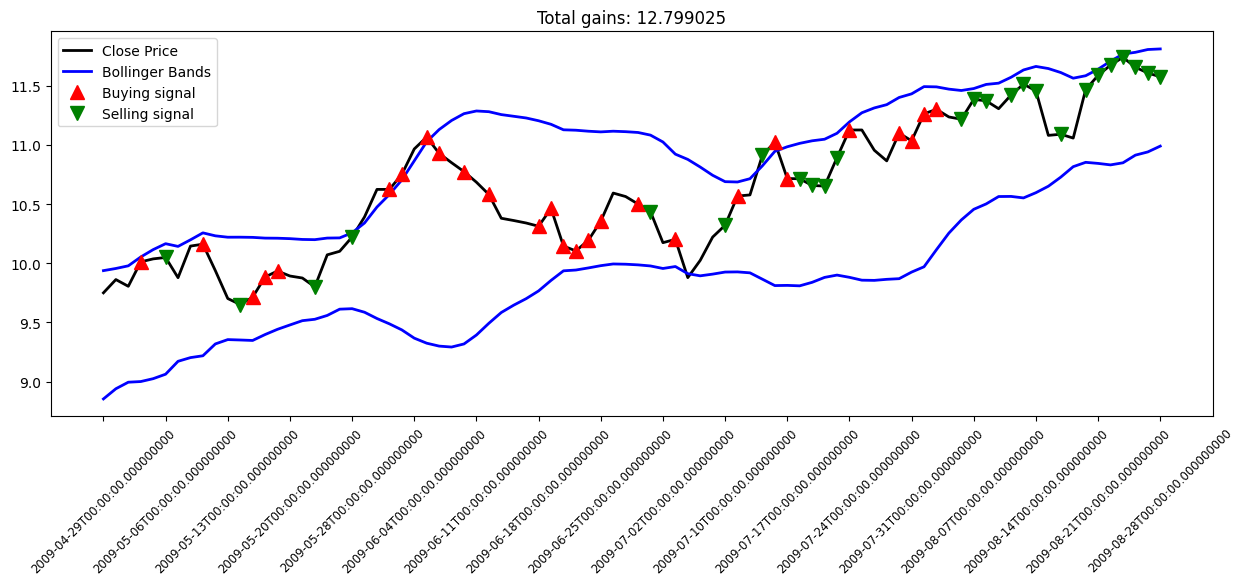

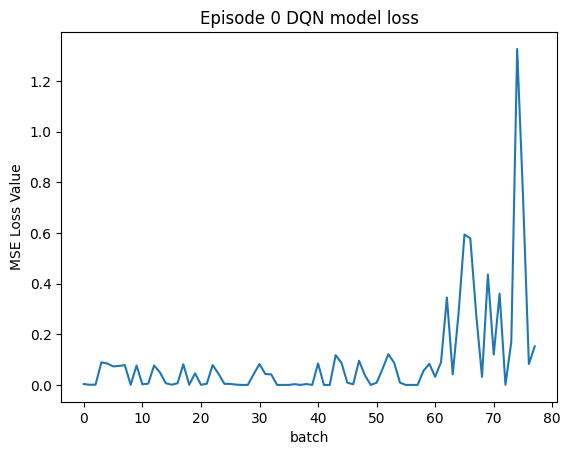

Running episode 1/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $10.01
Buy at: $9.88
Sell at: $10.15 | Profit: $0.13
Sell at: $9.94 | Profit: $0.06
Buy at: $9.89
Sell at: $9.88 | Profit: -$0.02
Buy at: $11.13
Sell at: $10.96 | Profit: -$0.17
Buy at: $11.46
Sell at: $11.08 | Profit: -$0.38
--------------------------------
Episode 1
Total Profit: -$0.37
Total Winners: $0.19
Total Losers: -$0.56
Max Loss: 1.1412617396053975
Total Loss: 27.952216442855285
--------------------------------


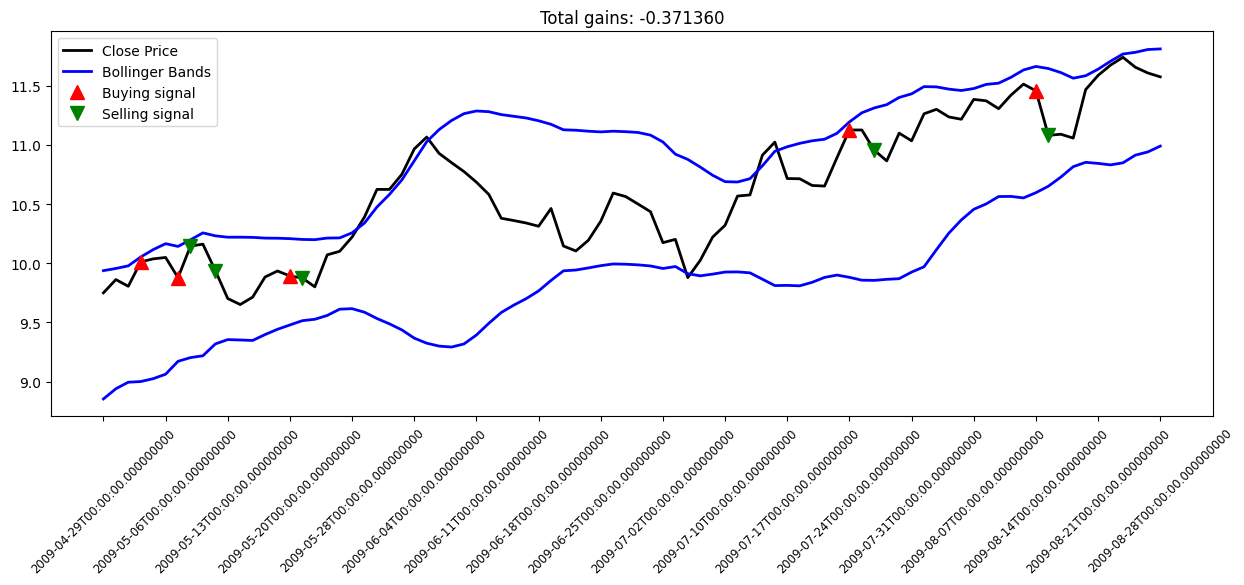

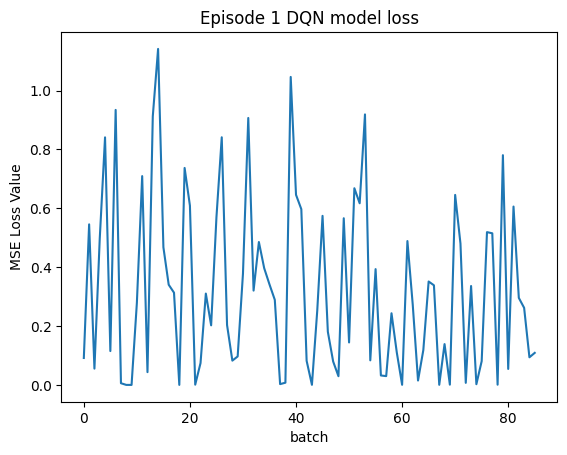

Running episode 2/2:   0%|          | 0/86 [00:00<?, ?it/s]

Buy at: $10.31
Sell at: $10.46 | Profit: $0.15
Buy at: $11.26
Buy at: $11.30
Sell at: $11.24 | Profit: -$0.03
Sell at: $11.22 | Profit: -$0.08
--------------------------------
Episode 2
Total Profit: $0.04
Total Winners: $0.15
Total Losers: -$0.11
Max Loss: 0.9430699167932357
Total Loss: 15.62170857151115
--------------------------------


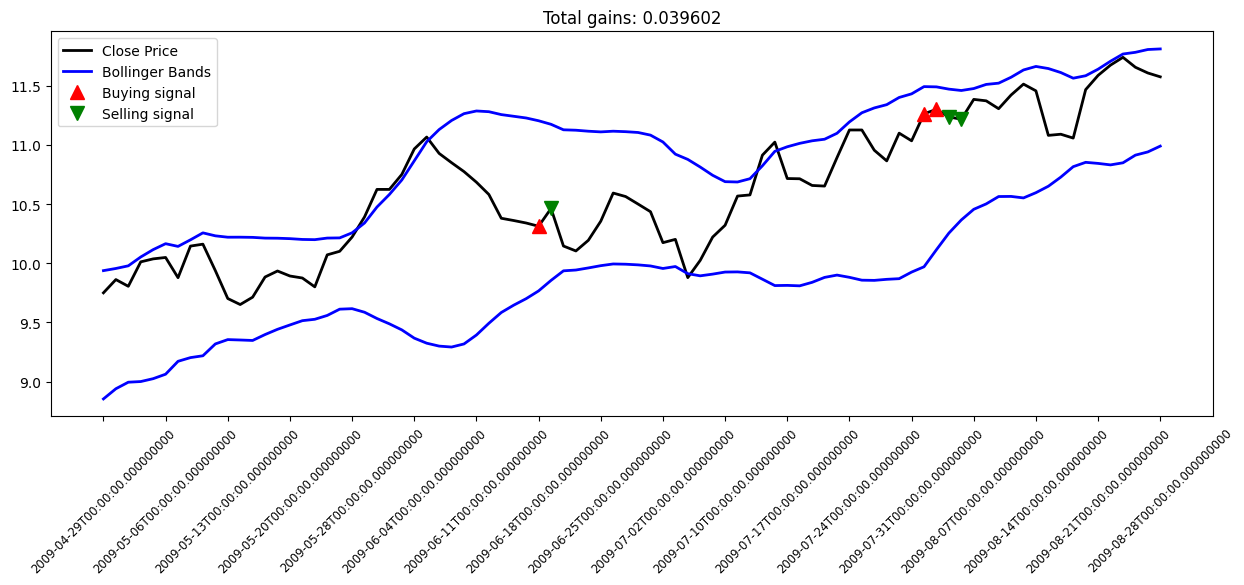

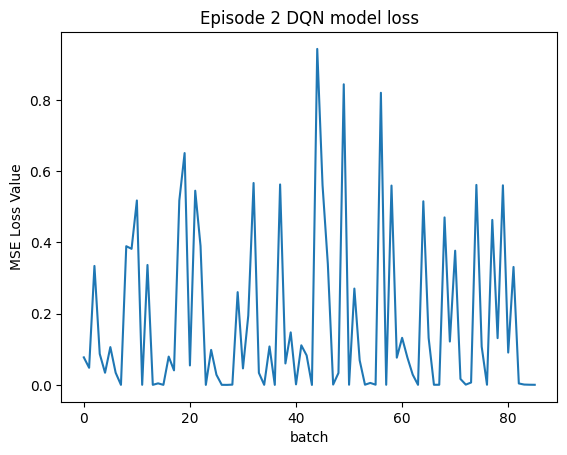

In [24]:
keras.config.disable_traceback_filtering()  # disable built-in keras loading bars

l = len(X_train)  # Track number of examples in dataset (number of days to train on)

# Batch size defines how often to run the exp_replay method
batch_size = 8 #32

# An episode represents a complete pass over the data
episode_count = 2 # = 2

# Get normalizers for Close, BB Upper, and BB Lower
normalizer_close = normlist[idx_close]
normalizer_bb_upper = normlist[idx_bb_upper]
normalizer_bb_lower = normlist[idx_bb_lower]

# Inverse transform true price and BB values for plotting
X_train_true_price = normalizer_close.inverse_transform(X_train[:, idx_close].reshape(-1, 1)).flatten()
X_train_true_bb_upper = normalizer_bb_upper.inverse_transform(X_train[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_train_true_bb_lower = normalizer_bb_lower.inverse_transform(X_train[:, idx_bb_lower].reshape(-1, 1)).flatten()

batch_losses = []
num_batches_trained = 0

for e in range(episode_count + 1):
    state = get_state(X_train, 0, window_size)  # Get the state for the first step
    
    # Initialize variables
    total_profit = 0
    total_winners = 0
    total_losers = 0
    agent.inventory = []
    states_sell = []
    states_buy = []

    for t in tqdm(range(l), desc=f'Running episode {e}/{episode_count}'):
        action = agent.act(state)  # Get the action
        next_state = get_state(X_train, t + 1, window_size)  # Get the next state

        reward = 0  # Initialize reward for the current time step

        if action == 1:  # Buy
            buy_price = normalizer_close.inverse_transform(X_train[t, idx_close].reshape(-1, 1))[0, 0]
            agent.inventory.append(buy_price)
            states_buy.append(t)
            print(f"Buy at: {format_price(buy_price)}")

        elif action == 2 and len(agent.inventory) > 0:  # Sell
            bought_price = agent.inventory.pop(0)
            sell_price = normalizer_close.inverse_transform(X_train[t, idx_close].reshape(-1, 1))[0, 0]
            trade_profit = sell_price - bought_price
            reward = trade_profit
            total_profit += trade_profit

            if trade_profit >= 0:
                total_winners += trade_profit
            else:
                total_losers += trade_profit

            states_sell.append(t)
            print(f"Sell at: {format_price(sell_price)} | Profit: {format_price(trade_profit)}")

        done = True if t == l - 1 else False  # Flag for final training iteration

        agent.memory.append((state, action, reward, next_state, done))  # Append details to memory
        state = next_state

        # Perform experience replay
        if len(agent.memory) > batch_size:
            loss = agent.exp_replay(batch_size, batch_losses)
            batch_losses.append(sum(loss))

        # Print total profit and plot behavior at the end of the episode
        if done:
            print('--------------------------------')
            print(f'Episode {e}')
            print(f'Total Profit: {format_price(total_profit)}')
            print(f'Total Winners: {format_price(total_winners)}')
            print(f'Total Losers: {format_price(total_losers)}')
            print(f'Max Loss: {max(batch_losses[num_batches_trained:]) if batch_losses else 0}')
            print(f'Total Loss: {sum(batch_losses[num_batches_trained:]) if batch_losses else 0}')
            print('--------------------------------')

            plot_behavior(X_train_true_price, X_train_true_bb_upper, X_train_true_bb_lower, states_buy, states_sell, total_profit)
            plot_losses(batch_losses[num_batches_trained:], f'Episode {e} DQN model loss')
            num_batches_trained = len(batch_losses)

    # Save the model every 2 episodes
    if e % 2 == 0:
        agent.model.save(f'model_ep{e}.keras')


### Plot Training Loss

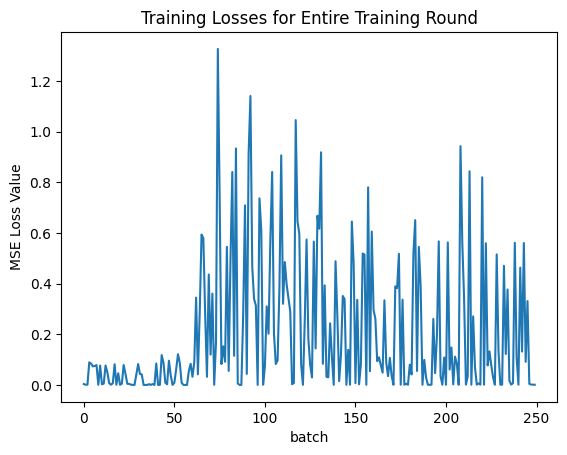

In [25]:
# use the plot_losses function to plot all batch_losses for the entire training round
plot_losses(batch_losses, "Training Losses for Entire Training Round")

# 9. Test the trained agent 
Finally, we get to test our trained model to see how well it performs in our test set. Using the training loop above, define a method to run our trained model on our X_test dataset. 

### Define Parameters
Some test parameters are defined for you below. Fill out the missing data. If you need a hint, look up at the training loop. 

In [26]:
# Define Parameters
l_test = len(X_test) - 1
state = get_state(X_test, 0, window_size)
total_profit = 0
done = False
states_sell_test = []
states_buy_test = []

# Get the trained model
agent = Agent(window_size, num_features=X_test.shape[1], test_mode=True, model_name=f'model_ep{episode_count}.keras')
agent.inventory = []

# Get the first state of the test dataset
state = get_state(X_test, 0, window_size)

# Inverse transform to get true prices for plotting
X_test_true_price = normalizer_close.inverse_transform(X_test[:, idx_close].reshape(-1, 1)).flatten()
X_test_true_bb_upper = normalizer_bb_upper.inverse_transform(X_test[:, idx_bb_upper].reshape(-1, 1)).flatten()
X_test_true_bb_lower = normalizer_bb_lower.inverse_transform(X_test[:, idx_bb_lower].reshape(-1, 1)).flatten()


### Run the Test
Run the test data through the trained model. Look at the training loop for a hint.

Buy: $13.05
Sell: $13.10 | Profit: $0.05
Buy: $13.66
Sell: $13.46 | Profit: -$0.20
Buy: $14.12
Sell: $14.14 | Profit: $0.03
Buy: $14.60
Sell: $14.62 | Profit: $0.02
------------------------------------------
Total Profit: $0.10
------------------------------------------


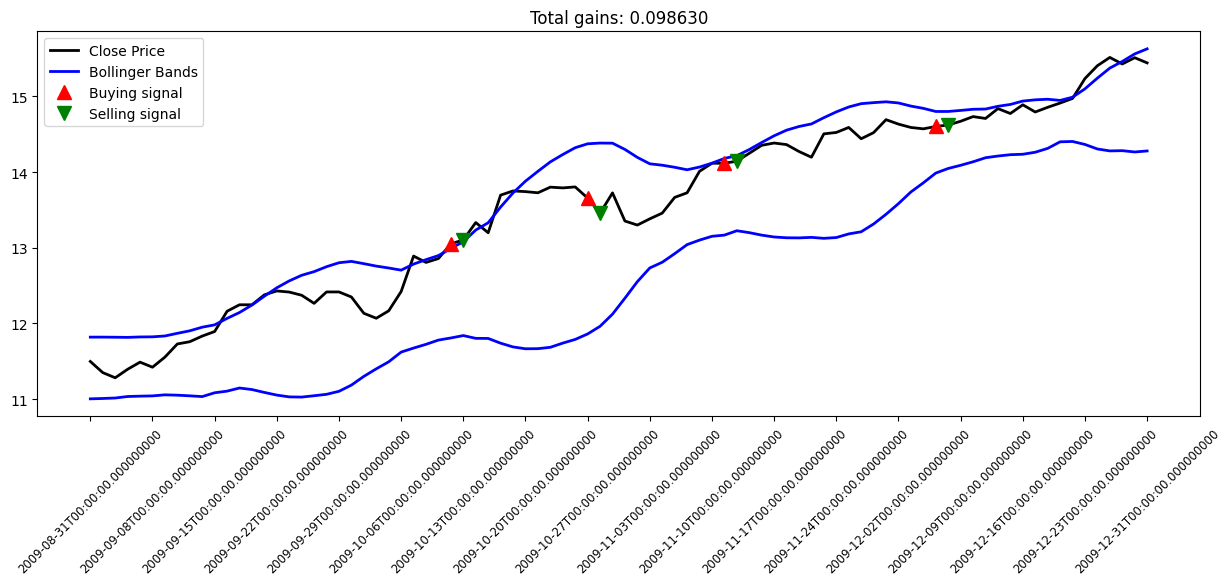

In [27]:
# Run the Test
for t in range(l_test):
    action = agent.act(state)
    next_state = get_state(X_test, t + 1, window_size)  # Get the next state in the test dataset
    reward = 0

    if action == 1:  # Buy
        buy_price = normalizer_close.inverse_transform(X_test[t, idx_close].reshape(-1, 1))[0, 0]
        agent.inventory.append(buy_price)
        states_buy_test.append(t)
        print(f'Buy: {format_price(buy_price)}')

    elif action == 2 and len(agent.inventory) > 0:  # Sell
        bought_price = agent.inventory.pop(0)  # Get the bought price
        sell_price = normalizer_close.inverse_transform(X_test[t, idx_close].reshape(-1, 1))[0, 0]
        reward = max(sell_price - bought_price, 0)
        total_profit += reward
        states_sell_test.append(t)
        print(f'Sell: {format_price(sell_price)} | Profit: {format_price(sell_price - bought_price)}')

    if t == l_test - 1:
        done = True

    # Append to memory for potential re-training on test data later
    agent.memory.append((state, action, reward, next_state, done))
    state = next_state

    if done:
        print('------------------------------------------')
        print(f'Total Profit: {format_price(total_profit)}')
        print('------------------------------------------')

# Plot test results
plot_behavior(X_test_true_price, X_test_true_bb_upper, X_test_true_bb_lower, states_buy_test, states_sell_test, total_profit, train=False)
